# Part 2: Segmentation with Clustering

In [14]:
import os
import datetime
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

For this tutorial, we are going to create several clustering algorithms and, most importantly, analyze and interpret the result. We are going to use cleaned and preprocessed data from our first class. However, the data is not yet fully ready for use. We need to convert it to a customer level dataset.

In [3]:
# Load the data
filename = 'data_cleared.csv'
path = os.path.join('data', filename) 

data = pd.read_csv(path)
data.drop(columns=['Unnamed: 0'], inplace=True)

data['InvoiceNo'] = data['InvoiceNo'].astype('O')
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data.head()

C:\Users\tkaramyan\AppData\Local\Temp\ipykernel_24968\771198092.py:5: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,OrderHour,OrderMonth,OrderWeekday
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,8,12,2
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,8,12,2
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,8,12,2
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,8,12,2
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,8,12,2


For the first model, we are going to create an RFM table as we did [in the previous lesson.](https://github.com/Tigran-Karamyan/customer_behaviour/blob/master/Week_6_Basics_of_Segmentation_RFM.ipynb) 

In [4]:
# create RFM
index_columns = ['CustomerID', 'InvoiceDate']
dt = data.groupby(index_columns, as_index=False).agg(
    {'TotalPrice': 'sum'}
)

dt.rename(columns={'TotalPrice': 'Budget'}, inplace=True)
dt.head()

,CustomerID,InvoiceDate,Budget
0,12347.0,2010-12-07 14:57:00,711.79
1,12347.0,2011-01-26 14:30:00,475.39
2,12347.0,2011-04-07 10:43:00,636.25
3,12347.0,2011-06-09 13:01:00,382.52
4,12347.0,2011-08-02 08:48:00,584.91


In [5]:
now = datetime.datetime(2011,12,10)

rfm= dt.groupby('CustomerID').agg(
    {'InvoiceDate': lambda date: (now - date.max()).days,
     'CustomerID': 'count',
     'Budget': 'mean'}
)

rfm.columns=['recency', 'frequency', 'monetary',]
rfm.reset_index(inplace=True)
rfm.head()

,CustomerID,recency,frequency,monetary
0,12347.0,2,7,615.714286
1,12348.0,75,4,359.310000
2,12349.0,18,1,1457.550000
3,12350.0,310,1,294.400000
4,12352.0,36,7,197.962857


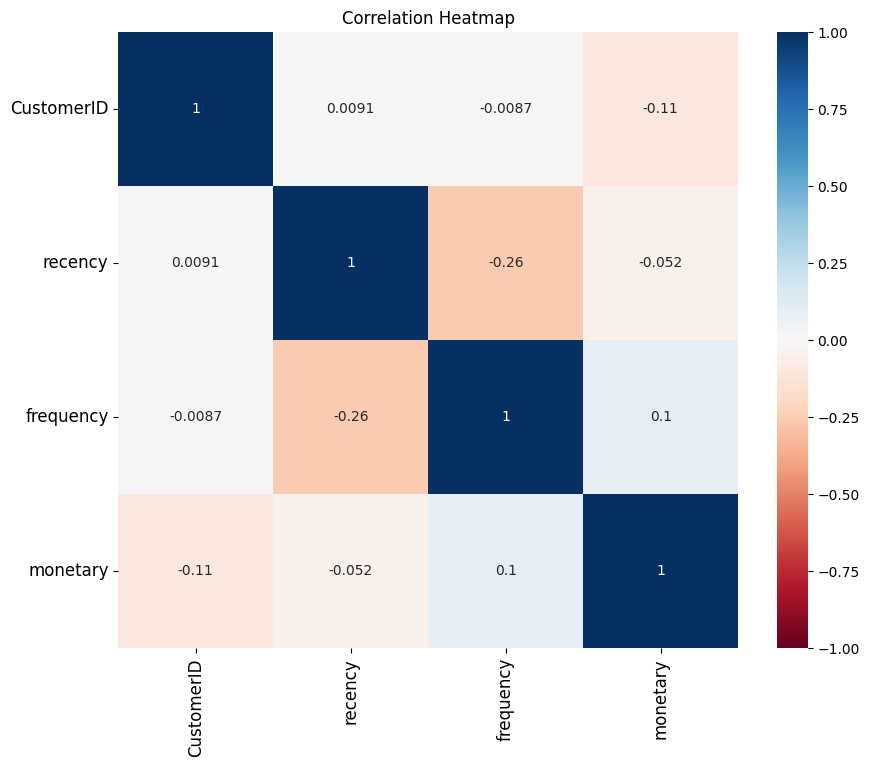

In [6]:
# Compute Pearson correlation coefficient for the features in our data set.
plt.figure(figsize = (10, 8))
s = sns.heatmap(rfm.corr(),
               annot = True, 
               cmap = 'RdBu',
               vmin = -1, 
               vmax = 1)

s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')
plt.show()

In [7]:
preprocessor = Pipeline(
    [
        ("scaler", StandardScaler()),
        # ("pca", PCA(n_components=2, random_state=42)),
    ]
)

In [8]:
clustered_data = rfm.drop(columns='CustomerID')
scaled_cluster_data = preprocessor.fit_transform(clustered_data)

## ${\textbf{Hierarchical Clustering}}$

Hierarchical clustering starts by treating each observation as a separate cluster. Then, it repeatedly executes the following two steps: 
1. identify the two clusters that are closest together 
2. merge the two most similar clusters. This iterative process continues until all the clusters are merged together

The main output of Hierarchical Clustering is a dendrogram, which shows the hierarchical relationship between the clusters.

[Ward Method](https://jbhender.github.io/Stats506/F18/GP/Group10.html)

In [9]:
hier_clust = linkage(scaled_cluster_data, method = 'ward')

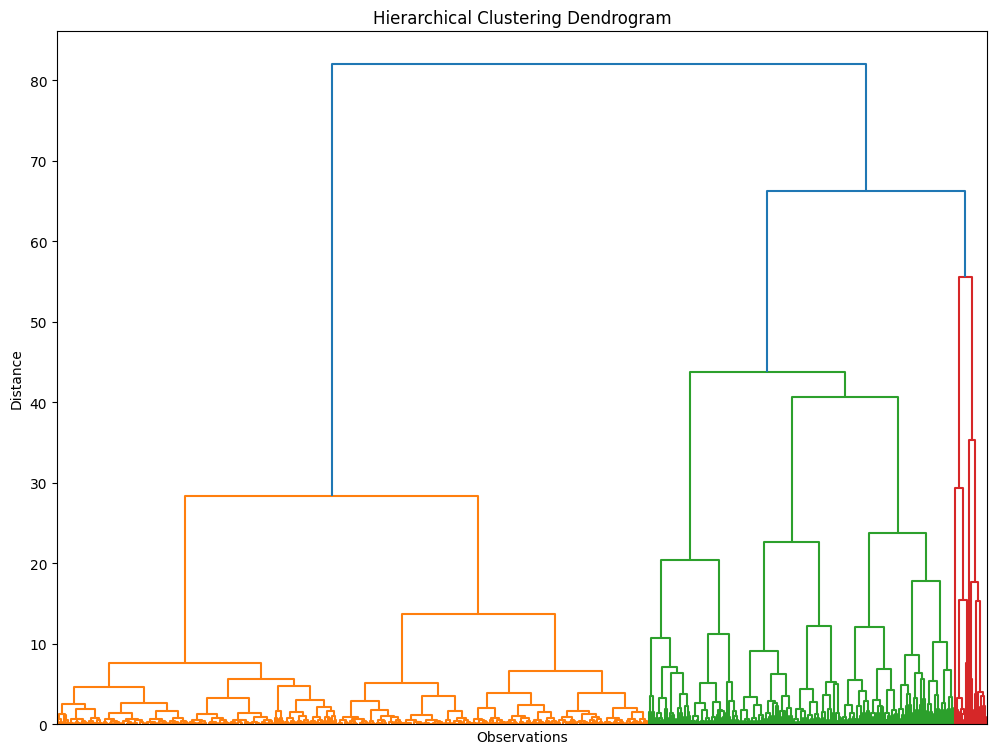

In [10]:
# We plot the results from the Hierarchical Clustering using a Dendrogram. 
plt.figure(figsize = (12,9))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Distance')
dendrogram(hier_clust,
           truncate_mode = 'level', 
           p = 10,
           no_labels = True)
plt.show()

The dendrogram shows that we have 3 different clusters. However, hierarchical clustering is not the most popular and advanced segmentation method. Anyway, it can help us get some preliminary insight about our data and customers, as well as we will get more understanding about how to use other machine learning algorithms such as K-Means.

## ${\textbf{K-means Clustering}}$

To process the learning data, the K-means algorithm in data mining starts with a first group of randomly selected centroids, which are used as the beginning points for every cluster, and then performs iterative (repetitive) calculations to optimize the positions of the centroids. 

**Silhouette Score**

The Silhouette Score measures how well-separated clusters are without needing ground truth labels. It evaluates:

- *Cohesion: How close a point is to its own cluster.*
- *Separation: How far a point is from other clusters.*

Key Properties
- Ranges from -1 to 1:
- 1 → Well-clustered (good separation).
- -1 → Overlapping clusters (unclear boundary).
- Negative values → Misclassified points (closer to another cluster).
- No ground truth required, useful for evaluating unsupervised clustering.

In [12]:
clustered_data

,recency,frequency,monetary
0,2,7,615.714286
1,75,4,359.310000
2,18,1,1457.550000
3,310,1,294.400000
4,36,7,197.962857
...,...,...,...
4329,277,1,180.600000
4330,180,1,80.820000
4331,7,2,89.025000
4332,3,16,130.558125


In [15]:
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2, random_state=42)),
    ]
)

In [16]:
engine = Pipeline(
    [
        (
            "kmeans",
            KMeans(
                n_clusters=4,
                init="k-means++",
                n_init=50,
                max_iter=500,
                random_state=42,
            ),
        )
    ]
)

In [17]:
pipe = Pipeline([("preprocessor", preprocessor), ("engine", engine)])

In [18]:
pipe.fit(clustered_data)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('engine',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=4, n_init=50,
                                         random_state=42))]))])

In [22]:
pipe['engine']['kmeans'].labels_

array([2, 0, 2, ..., 2, 2, 2])

In [23]:
pipe['engine']['kmeans'].inertia_

22.95946566984094

In [25]:
# Loop and count Within Cluster Sum of Squares
wcss = []
for k in range(2,11):
    pipe['engine']['kmeans'].n_clusters = k
    
    pipe.fit(clustered_data)
    wcss.append(pipe['engine']['kmeans'].inertia_)
    print(f"K {k} is Done")

K 2 is Done
K 3 is Done
K 4 is Done
K 5 is Done
K 6 is Done
K 7 is Done
K 8 is Done
K 9 is Done
K 10 is Done


In [26]:
wcss

[69.88692824906619,
 36.561682115499224,
 22.959465669840945,
 16.373959317697643,
 12.998385940769968,
 10.479009742875327,
 8.620197628170994,
 7.249721379103696,
 6.1548075927811965]

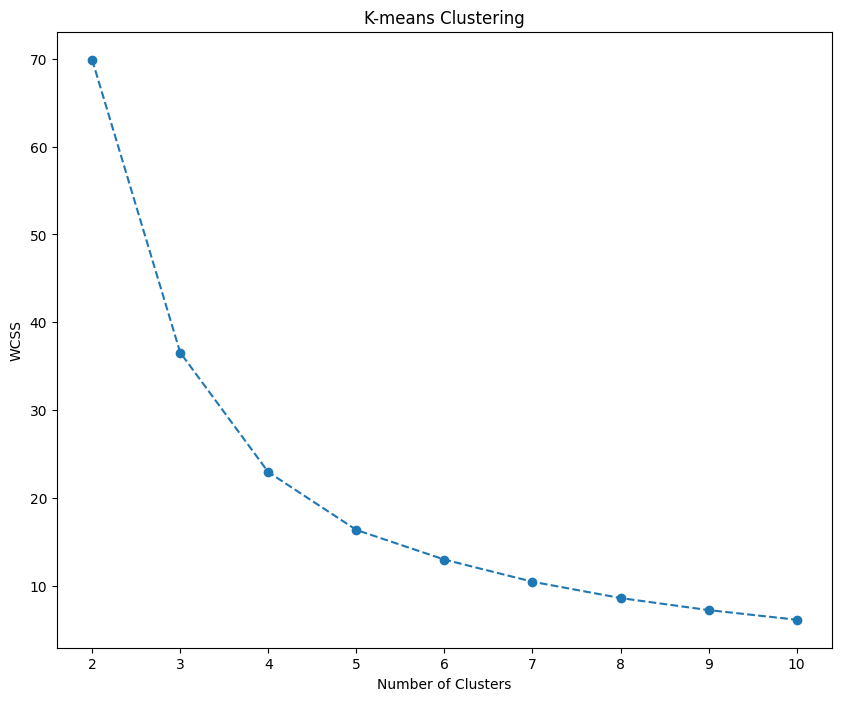

In [27]:
plt.figure(figsize = (10,8))
plt.plot(range(2, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.show()

In [47]:
pipe['engine']['kmeans'].n_clusters = 4 

In [48]:
pipe.fit(clustered_data)
labels = pipe['engine']['kmeans'].labels_

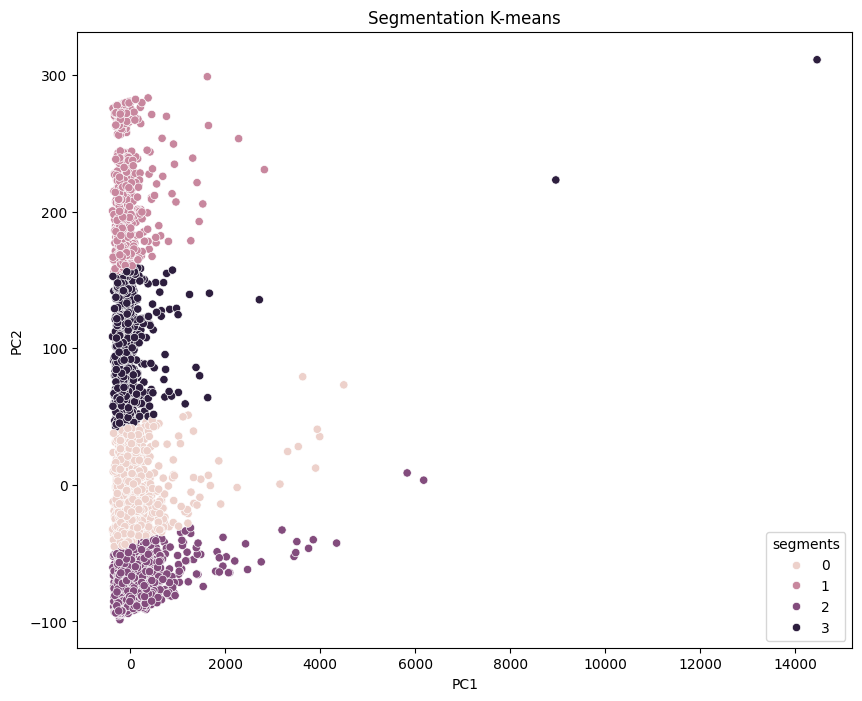

In [49]:
data = pipe['preprocessor']['pca'].fit_transform(clustered_data)
df = pd.DataFrame(data, columns = ['PC1', 'PC2'])
df['segments'] = labels
df
plt.figure(figsize = (10, 8))
sns.scatterplot(df, x='PC1', y='PC2', hue='segments')
plt.title('Segmentation K-means')
plt.show()

In [29]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
kmeans.fit(data_stand)

KMeans(n_clusters=4, random_state=42)

Using the Elbow method, we see that we can distinguish 4 clusters. Now let's interpret the results.

### ${\textbf{Results}}$

In [30]:
segm_labels = cluster_data.copy()
segm_labels['Segments'] = kmeans.labels_
segm_labels.head()

,recency,frequency,monetary,Segments
0,2,7,615.714286,0
1,75,4,359.310000,0
2,18,1,1457.550000,0
3,310,1,294.400000,1
4,36,7,197.962857,0


In [31]:
profiling = segm_labels.groupby(['Segments'], as_index=False).mean()
profiling

,Segments,recency,frequency,monetary
0,0,40.944966,4.604753,363.161034
1,1,246.547222,1.571296,294.227317
2,2,66.416667,9.083333,3901.680096
3,3,5.200000,78.600000,909.886215


In [32]:
#Create new columns: Segment size and Segment proportion 
profiling['Segment_size'] = segm_labels.groupby(['Segments'])['Segments'].count()
profiling['Segment_prop'] = round(profiling['Segment_size'] / profiling['Segment_size'].sum() * 100, 2)

# Add the segment labels to our table
profiling['Segments'] = profiling['Segments'].map({0:'promising', 
                                                   1:'champions',
                                                   2:'lost', 
                                                   3:'high spenders'})

profiling

,Segments,recency,frequency,monetary,Segment_size,Segment_prop
0,promising,40.944966,4.604753,363.161034,3198,73.79
1,champions,246.547222,1.571296,294.227317,1080,24.92
2,lost,66.416667,9.083333,3901.680096,36,0.83
3,high spenders,5.200000,78.600000,909.886215,20,0.46


In [33]:
segm_labels['Segments'] = segm_labels['Segments'].map({0:'promising', 
                                                   1:'champions',
                                                   2:'lost', 
                                                   3:'high spenders'})

segm_labels.head()

,recency,frequency,monetary,Segments
0,2,7,615.714286,promising
1,75,4,359.310000,promising
2,18,1,1457.550000,promising
3,310,1,294.400000,champions
4,36,7,197.962857,promising


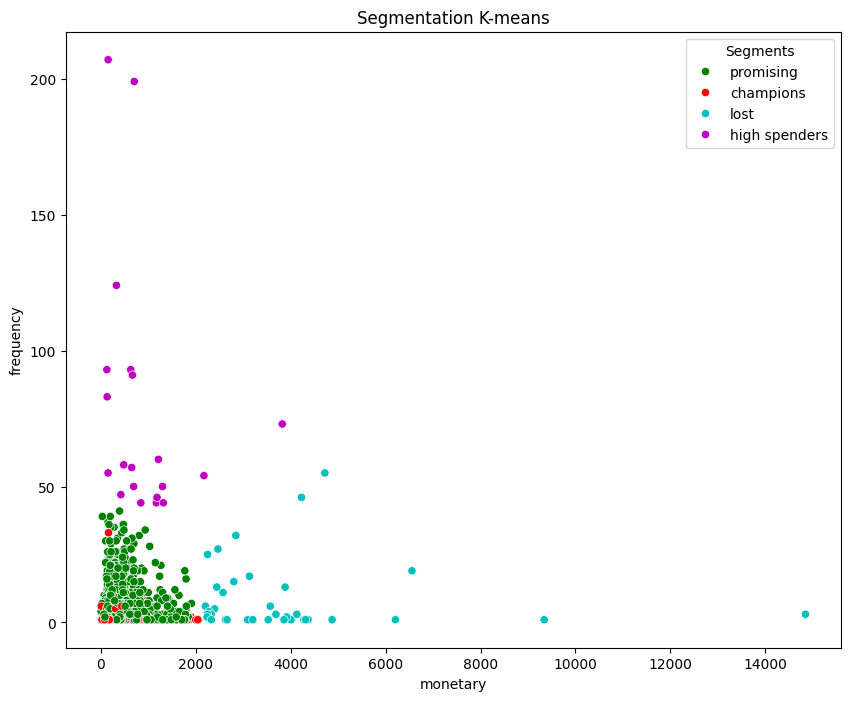

In [35]:
plt.figure(figsize = (10, 8))
sns.scatterplot(data=segm_labels,x='monetary', y='frequency', hue = 'Segments', palette = ['g', 'r', 'c', 'm'])
plt.title('Segmentation K-means')
plt.show()

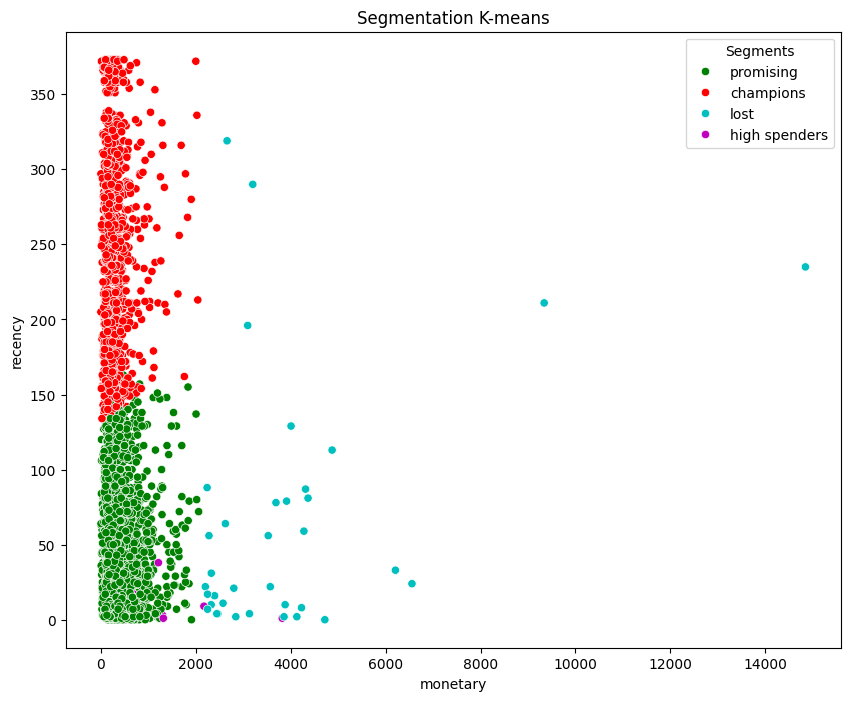

In [36]:
plt.figure(figsize = (10, 8))
sns.scatterplot(data=segm_labels, x='monetary', y='recency', hue = 'Segments', palette = ['g', 'r', 'c', 'm'])
plt.title('Segmentation K-means')
plt.show()

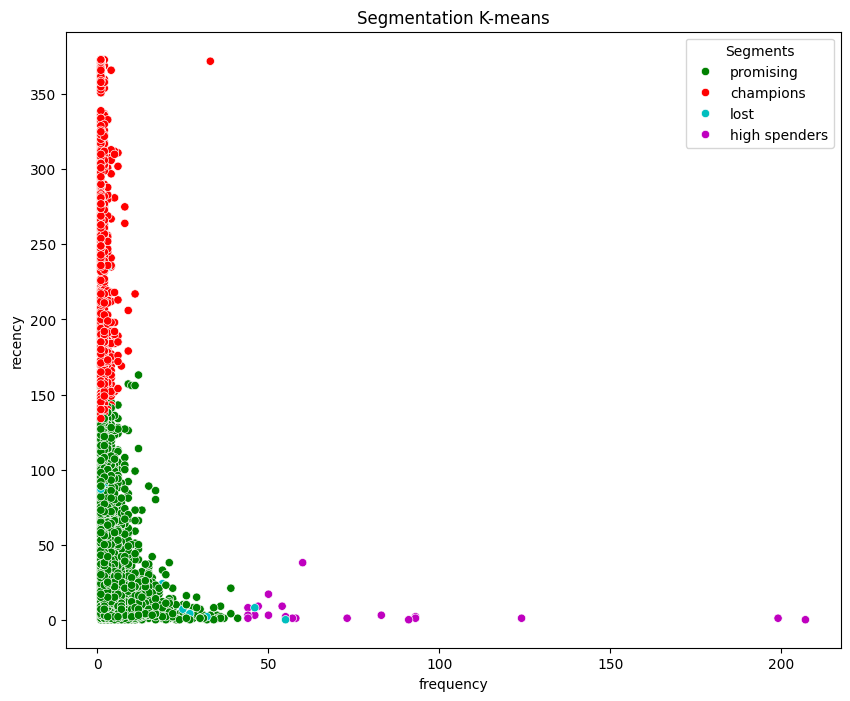

In [37]:
plt.figure(figsize = (10, 8))
sns.scatterplot(data=segm_labels, x='frequency', y='recency', hue = 'Segments', palette = ['g', 'r', 'c', 'm'])
plt.title('Segmentation K-means')
plt.show()

# Add more features

Now let's add some more features and see if the results are changing.

In [38]:
dt = data.groupby(['CustomerID', 'InvoiceDate'], as_index=False).agg({'TotalPrice': 'sum', 
                                                                      'Quantity' : 'sum', 
                                                                      "InvoiceNo" : 'count'})

customer_data = dt.groupby(['CustomerID']).agg(AvgQuantity = ('Quantity', 'mean'), 
                                               AvgDifferentProducts = ('InvoiceNo', 'mean'),
                                               Recency = ('InvoiceDate', lambda date: (now - date.max()).days),
                                               Frequency = ('CustomerID', 'count'),
                                               Monetary_Value = ('TotalPrice', 'mean'),
                                               GapBetweenOrders = ('InvoiceDate', lambda date: (date.max() - date.min()).days)
                                              )

customer_data.head()

,AvgQuantity,AvgDifferentProducts,Recency,Frequency,Monetary_Value,GapBetweenOrders
CustomerID,,,,,,
12347.0,351.142857,26.00,2,7,615.714286,365
12348.0,583.000000,6.75,75,4,359.310000,282
12349.0,630.000000,72.00,18,1,1457.550000,0
12350.0,196.000000,16.00,310,1,294.400000,0
12352.0,75.142857,11.00,36,7,197.962857,260


In [39]:
data_stand = scaler.fit_transform(customer_data)

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, random_state = 42)
    kmeans.fit(data_stand)
    wcss.append(kmeans.inertia_)

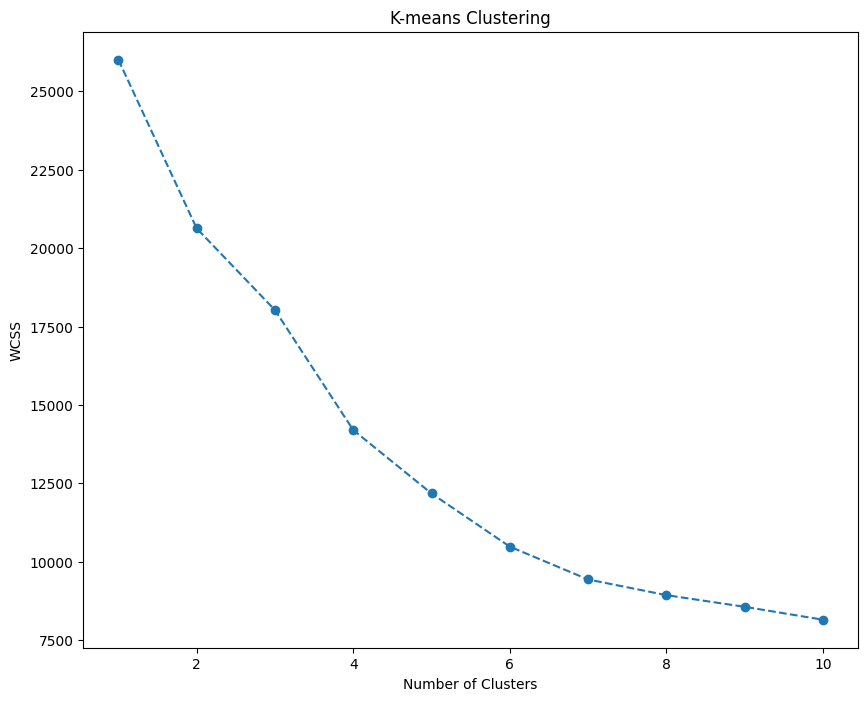

In [40]:
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.show()

In [41]:
kmeans = KMeans(n_clusters = 3,  random_state = 42)
kmeans.fit(data_stand)

KMeans(n_clusters=3, random_state=42)

In [42]:
segm_labels = customer_data.copy()
segm_labels['Segments'] = kmeans.labels_
segm_labels.head()

,AvgQuantity,AvgDifferentProducts,Recency,Frequency,Monetary_Value,GapBetweenOrders,Segments
CustomerID,,,,,,,
12347.0,351.142857,26.00,2,7,615.714286,365,1
12348.0,583.000000,6.75,75,4,359.310000,282,1
12349.0,630.000000,72.00,18,1,1457.550000,0,0
12350.0,196.000000,16.00,310,1,294.400000,0,2
12352.0,75.142857,11.00,36,7,197.962857,260,1


In [43]:
profiling = segm_labels.groupby(['Segments'], as_index=False).mean()

profiling['Segment_size'] = segm_labels.groupby(['Segments'])['Segments'].count()
profiling['Segment_prop'] = round(profiling['Segment_size'] / profiling['Segment_size'].sum() * 100, 2)

profiling

,Segments,AvgQuantity,AvgDifferentProducts,Recency,Frequency,Monetary_Value,GapBetweenOrders,Segment_size,Segment_prop
0,0,299.829485,28.354247,55.013277,2.032589,458.866212,48.946288,1657,38.23
1,1,217.884498,20.446722,31.580882,8.175858,368.964994,280.968750,1632,37.66
2,2,139.042808,15.655832,245.943541,1.541627,263.464605,23.986603,1045,24.11


In [44]:
# Add the segment labels to our table
profiling['Segments'] = profiling['Segments'].map({0:'lost', 
                                                   1:'promising',
                                                   2:'champions'})

profiling

,Segments,AvgQuantity,AvgDifferentProducts,Recency,Frequency,Monetary_Value,GapBetweenOrders,Segment_size,Segment_prop
0,lost,299.829485,28.354247,55.013277,2.032589,458.866212,48.946288,1657,38.23
1,promising,217.884498,20.446722,31.580882,8.175858,368.964994,280.968750,1632,37.66
2,champions,139.042808,15.655832,245.943541,1.541627,263.464605,23.986603,1045,24.11


In [45]:
segm_labels['Segments'] = segm_labels['Segments'].map({0:'lost', 
                                                   1:'promising',
                                                   2:'champions'})

segm_labels.head()

,AvgQuantity,AvgDifferentProducts,Recency,Frequency,Monetary_Value,GapBetweenOrders,Segments
CustomerID,,,,,,,
12347.0,351.142857,26.00,2,7,615.714286,365,promising
12348.0,583.000000,6.75,75,4,359.310000,282,promising
12349.0,630.000000,72.00,18,1,1457.550000,0,lost
12350.0,196.000000,16.00,310,1,294.400000,0,champions
12352.0,75.142857,11.00,36,7,197.962857,260,promising


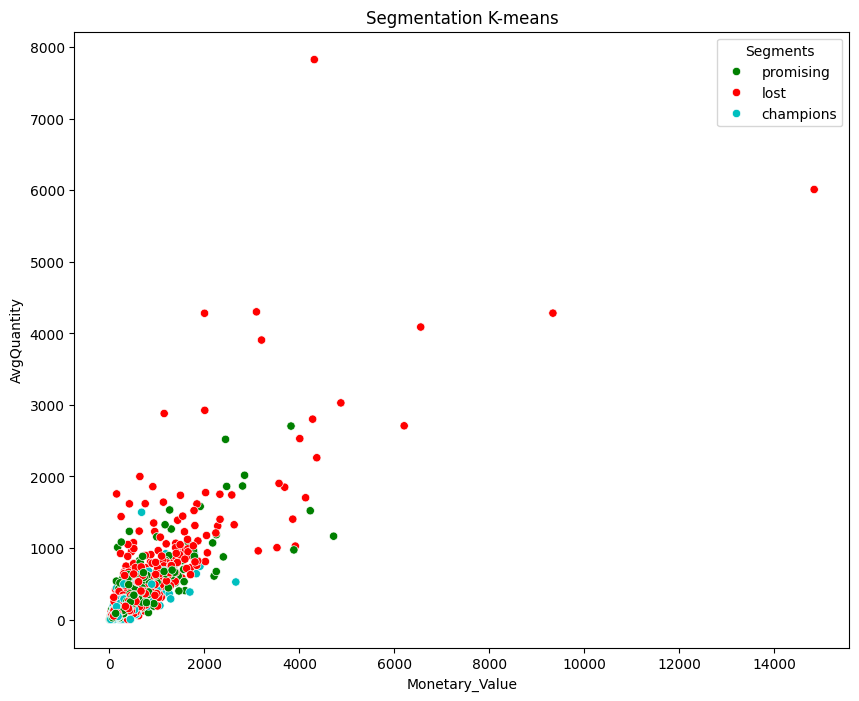

In [47]:
plt.figure(figsize = (10, 8))
sns.scatterplot(data=segm_labels, x='Monetary_Value', y='AvgQuantity', hue = 'Segments', palette = ['g', 'r', 'c'])
plt.title('Segmentation K-means')
plt.show()

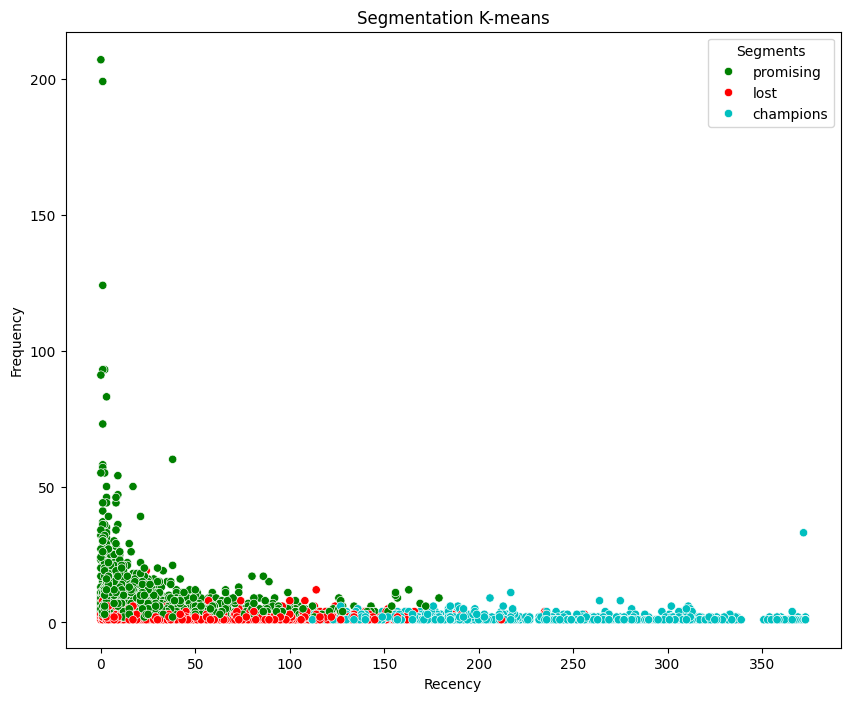

In [48]:
plt.figure(figsize = (10, 8))
sns.scatterplot(data=segm_labels, x='Recency', y='Frequency', hue = 'Segments', palette = ['g', 'r', 'c'])
plt.title('Segmentation K-means')
plt.show()

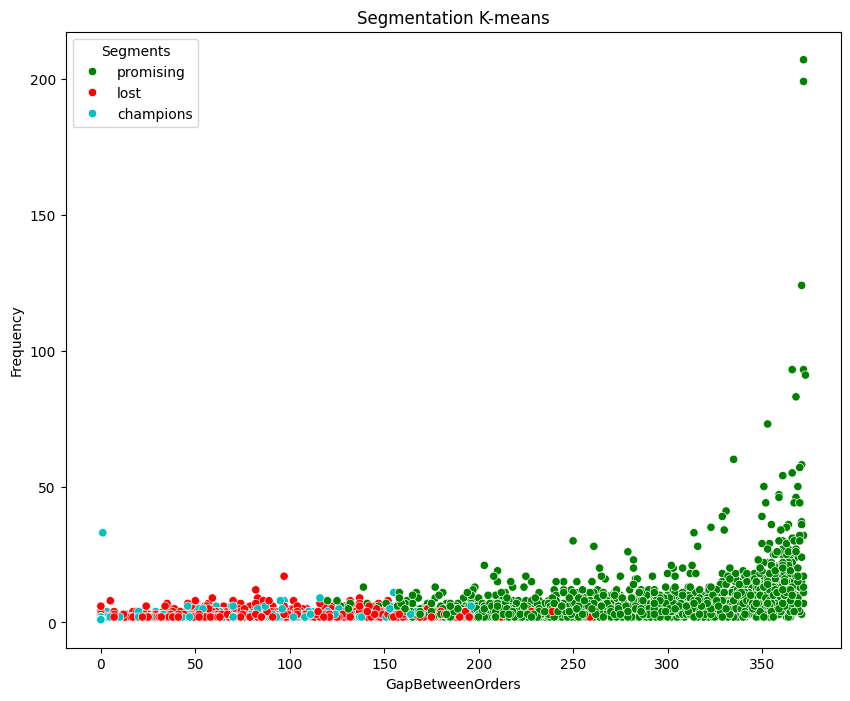

In [49]:
plt.figure(figsize = (10, 8))
sns.scatterplot(data=segm_labels, x='GapBetweenOrders', y='Frequency', hue = 'Segments', palette = ['g', 'r', 'c'])
plt.title('Segmentation K-means')
plt.show()
